In [39]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2

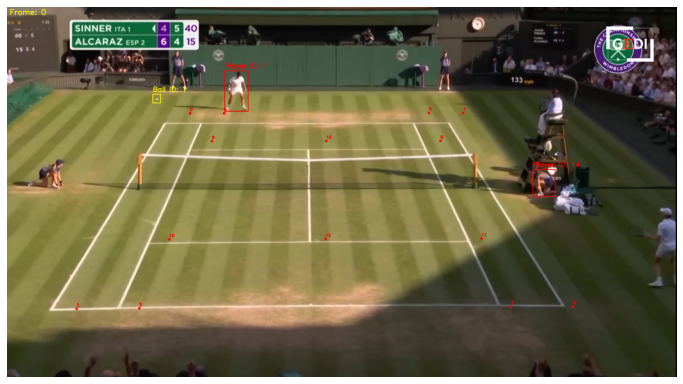

In [40]:
# Carica l'immagine con PIL
img_pred = Image.open('output_videos/output_image.png')

# Visualizza inline con matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(img_pred)
plt.axis('off')  # Nasconde gli assi
plt.show()


In [41]:
import json

keypoints_path = "output_videos/keypoints_coordinates.json"

with open(keypoints_path, "r") as f:
    keypoints = json.load(f)

print("Keypoints letti dal file:")
print(keypoints)


Keypoints letti dal file:
[718.2557373046875, 417.02880859375, 1790.0303955078125, 415.9437561035156, 273.4197998046875, 1184.024658203125, 2221.24755859375, 1175.3192138671875, 852.93505859375, 417.1521911621094, 519.2583618164062, 1182.7496337890625, 1656.6671142578125, 415.8350524902344, 1978.3232421875, 1176.3597412109375, 804.2763061523438, 526.834716796875, 1701.8460693359375, 525.2810668945312, 637.161376953125, 912.7958374023438, 1862.4061279296875, 908.9328002929688, 1253.5140380859375, 525.7800903320312, 1250.81494140625, 910.9224853515625]


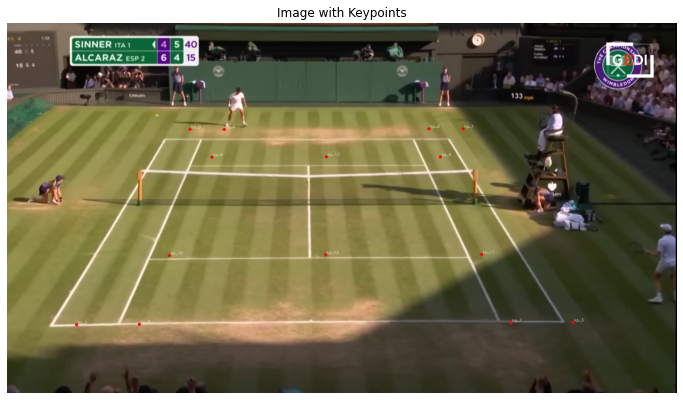

In [42]:
import cv2
import json
import os
import matplotlib.pyplot as plt

# === Percorsi ===
image_path = "input_videos/image_last_frame.png"
keypoints_path = "output_videos/keypoints_coordinates.json"

# === Carica immagine ===
image = cv2.imread(image_path)

# Converti immagine da BGR (OpenCV) a RGB (matplotlib)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image_original = image.copy()

# === Carica keypoints dal file JSON ===
with open(keypoints_path, "r") as f:
    keypoints_flat = json.load(f)

keypoints = [(int(keypoints_flat[i]), int(keypoints_flat[i+1])) for i in range(0, len(keypoints_flat), 2)]

# === Disegna i keypoints sull'immagine ===
for i, (x, y) in enumerate(keypoints):
    cv2.circle(image, (x, y), 6, (255, 0, 0), -1)  # colore rosso in RGB (BGR era blu)
    cv2.putText(image, f"kp_{i}", (x + 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

# === Mostra immagine con matplotlib nel notebook ===
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis("off")
plt.title("Image with Keypoints")
plt.show()


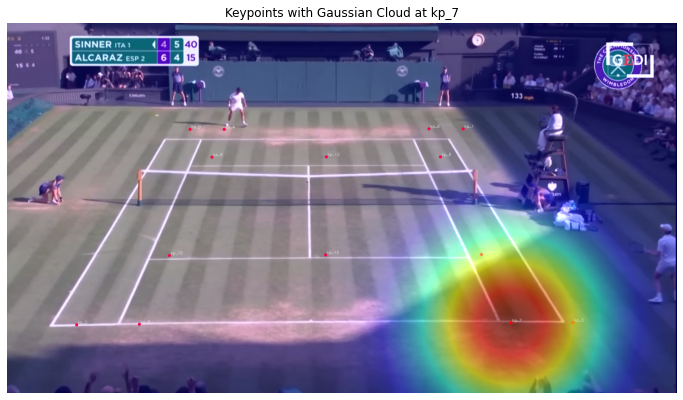

In [51]:
import cv2
import json
import os
import matplotlib.pyplot as plt
import numpy as np

# === Percorsi ===
image_path = "input_videos/image_last_frame.png"
keypoints_path = "output_videos/keypoints_coordinates.json"

# === Carica immagine ===
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_original = image.copy()

# === Carica keypoints dal file JSON ===
with open(keypoints_path, "r") as f:
    keypoints_flat = json.load(f)

keypoints = [(int(keypoints_flat[i]), int(keypoints_flat[i+1])) for i in range(0, len(keypoints_flat), 2)]

# === Disegna i keypoints sull'immagine ===
for i, (x, y) in enumerate(keypoints):
    cv2.circle(image, (x, y), 6, (255, 0, 0), -1)
    cv2.putText(image, f"kp_{i}", (x + 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

# === Crea nuvola gaussiana attorno al keypoint 7 ===
kp_index = 7
x0, y0 = keypoints[kp_index]

# Parametri della gaussiana
sigma = 250
height, width, _ = image.shape

# Meshgrid per creare la gaussiana
x = np.arange(0, width)
y = np.arange(0, height)
xx, yy = np.meshgrid(x, y)

# Formula della gaussiana 2D
gaussian = np.exp(-((xx - x0)**2 + (yy - y0)**2) / (2 * sigma**2))

# Normalizza e converte in heatmap colorata
heatmap = (gaussian * 255).astype(np.uint8)
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

# Sovrapponi heatmap con trasparenza
alpha = 0.5
overlay = cv2.addWeighted(image, 1.0, heatmap_color, alpha, 0)

# === Mostra risultato ===
plt.figure(figsize=(12, 8))
plt.imshow(overlay)
plt.axis("off")
plt.title("Keypoints with Gaussian Cloud at kp_7")
plt.show()


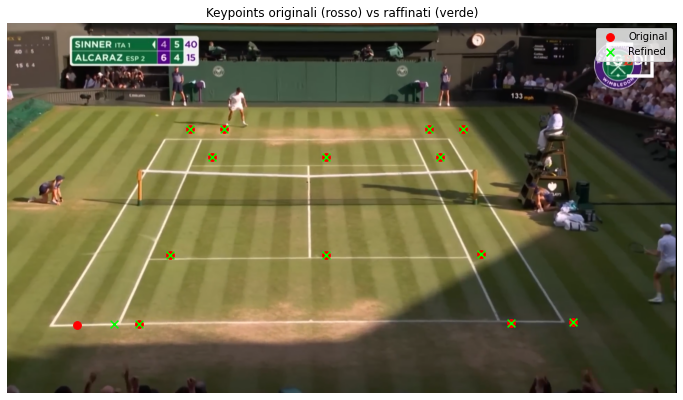

In [44]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def find_line_intersections(lines):
    intersections = []
    for i in range(len(lines)):
        for j in range(i+1, len(lines)):
            l1 = lines[i][0]
            l2 = lines[j][0]
            pt = compute_intersection(l1, l2)
            if pt is not None:
                intersections.append(pt)
    return intersections

def compute_intersection(line1, line2):
    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2

    denom = (x1 - x2)*(y3 - y4) - (y1 - y2)*(x3 - x4)
    if denom == 0:
        return None

    px = ((x1*y2 - y1*x2)*(x3 - x4) - (x1 - x2)*(x3*y4 - y3*x4)) / denom
    py = ((x1*y2 - y1*x2)*(y3 - y4) - (y1 - y2)*(x3*y4 - y3*x4)) / denom

    return (int(px), int(py))

def refine_keypoint(image, keypoint, window_size=20):
    x, y = keypoint

    h, w = image.shape[:2]
    x_min = max(x - window_size, 0)
    y_min = max(y - window_size, 0)
    x_max = min(x + window_size, w-1)
    y_max = min(y + window_size, h-1)

    roi = image[y_min:y_max, x_min:x_max]
    gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=30, minLineLength=10, maxLineGap=5)

    if lines is None or len(lines) < 2:
        return keypoint

    intersections = find_line_intersections(lines)
    if len(intersections) == 0:
        return keypoint

    keypoint_abs = np.array([x, y])
    intersections_arr = np.array(intersections)
    distances = np.linalg.norm(intersections_arr - keypoint_abs, axis=1)
    idx_min = np.argmin(distances)
    refined_point = intersections[idx_min]
    refined_point_global = (refined_point[0] + x_min, refined_point[1] + y_min)

    return refined_point_global

# === Carica immagine e keypoints ===
image = cv2.imread('input_videos/image_last_frame.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

refined_keypoints = [refine_keypoint(image, kp, window_size=25) for kp in keypoints]

# === Plot immagine e keypoints ===
plt.figure(figsize=(12,8))
plt.imshow(image)
plt.axis('off')

# Disegna keypoints originali in rosso
for (x, y) in keypoints:
    plt.scatter(x, y, c='red', s=60, label='Original' if 'Original' not in plt.gca().get_legend_handles_labels()[1] else "")

# Disegna keypoints raffinati in verde
for (x, y) in refined_keypoints:
    plt.scatter(x, y, c='lime', s=60, marker='x', label='Refined' if 'Refined' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.legend()
plt.title("Keypoints originali (rosso) vs raffinati (verde)")
plt.show()


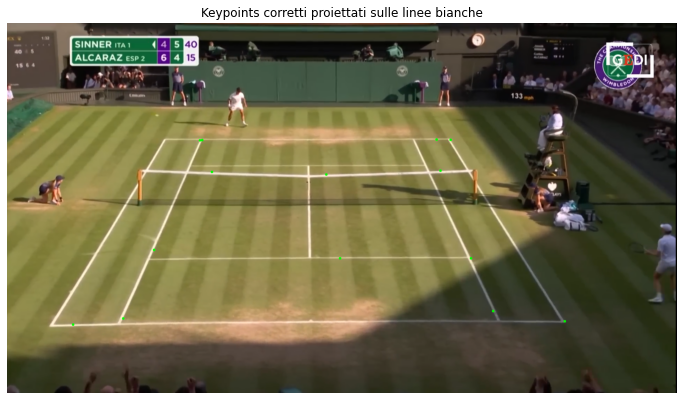

In [52]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Carica immagine
image_path = "input_videos/image_last_frame.png"
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 2. Estrai bordi
edges = cv2.Canny(gray, 100, 200)

# 3. Hough Transform per trovare linee
lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=120, minLineLength=50, maxLineGap=10)

# 4. Costruisci una maschera delle linee bianche
line_mask = np.zeros_like(gray)
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_mask, (x1, y1), (x2, y2), 255, 2)

# 5. Per ogni keypoint, trova il punto più vicino sulla linea
from scipy.spatial import cKDTree

# Coordinate dei pixel con linee (255)
ys, xs = np.where(line_mask == 255)
line_points = np.stack([xs, ys], axis=1)
tree = cKDTree(line_points)

# Keypoints originali
keypoints_np = np.array(keypoints)
corrected_keypoints = []

for (x, y) in keypoints_np:
    dist, idx = tree.query([x, y])
    x_corr, y_corr = line_points[idx]
    corrected_keypoints.append((int(x_corr), int(y_corr)))

# 6. Visualizza keypoints corretti
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
for (x, y) in corrected_keypoints:
    cv2.circle(image_rgb, (x, y), 5, (0, 255, 0), -1)  # Verde = corretto

plt.figure(figsize=(12, 8))
plt.imshow(image_rgb)
plt.title("Keypoints corretti proiettati sulle linee bianche")
plt.axis("off")
plt.show()


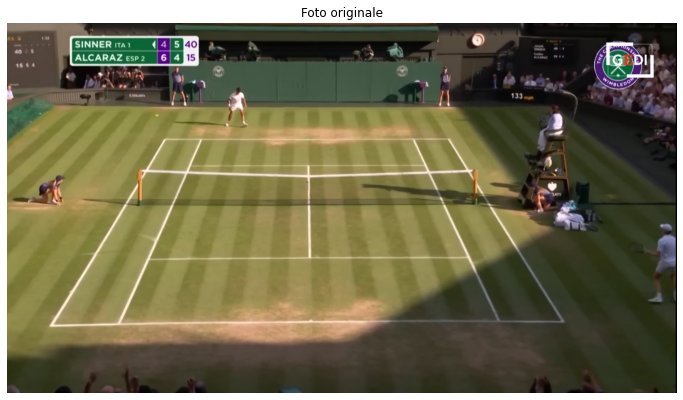

In [54]:
import cv2
import matplotlib.pyplot as plt

# === Percorso immagine ===
image_path = "input_videos/image_last_frame.png"

# === Carica e converti immagine ===
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# === Mostra immagine originale ===
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis("off")
plt.title("Foto originale")
plt.show()


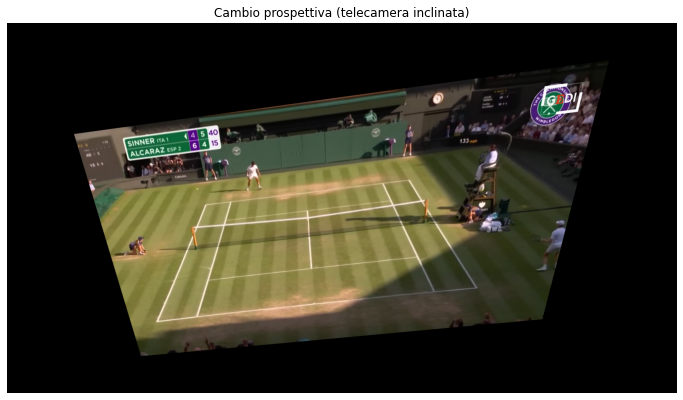

In [59]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread("input_videos/image_last_frame.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

(h, w) = image.shape[:2]

# Punti originali (es. rettangolo completo)
src_pts = np.float32([[0, 0], [w-1, 0], [0, h-1], [w-1, h-1]])

# Punti trasformati (simula l'inclinazione)
dst_pts = np.float32([
    [w*0.1, h*0.3],   # in alto a sinistra
    [w*0.9, h*0.1],   # in alto a destra
    [w*0.2, h*0.9],   # in basso a sinistra
    [w*0.8, h*0.8]    # in basso a destra
])

# Matrice di trasformazione prospettica
M = cv2.getPerspectiveTransform(src_pts, dst_pts)
warped = cv2.warpPerspective(image, M, (w, h))

plt.figure(figsize=(12, 8))
plt.imshow(warped)
plt.axis("off")
plt.title("Cambio prospettiva (telecamera inclinata)")
plt.show()


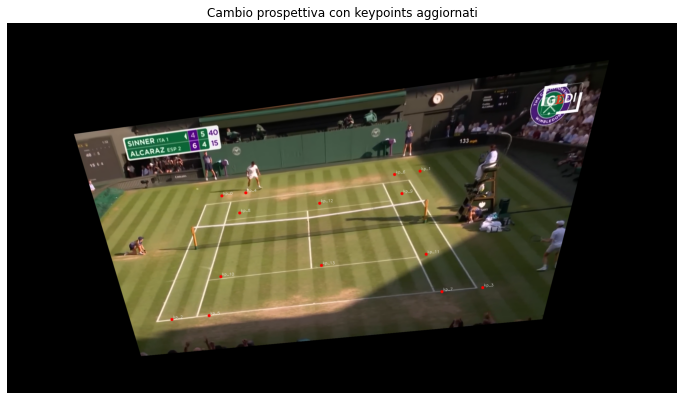

In [60]:
# === Trasformazione prospettica ===
src_pts = np.float32([
    [0, 0],
    [w - 1, 0],
    [0, h - 1],
    [w - 1, h - 1]
])
dst_pts = np.float32([
    [w * 0.1, h * 0.3],
    [w * 0.9, h * 0.1],
    [w * 0.2, h * 0.9],
    [w * 0.8, h * 0.8]
])

# Calcola matrice di trasformazione
M = cv2.getPerspectiveTransform(src_pts, dst_pts)
warped_image = cv2.warpPerspective(image, M, (w, h))

# Applica la trasformazione anche ai keypoints
keypoints_warped = []
for (x, y) in keypoints:
    pt = np.array([[[x, y]]], dtype='float32')  # shape (1, 1, 2)
    dst = cv2.perspectiveTransform(pt, M)
    keypoints_warped.append((int(dst[0][0][0]), int(dst[0][0][1])))

# Visualizza keypoints trasformati
for i, (x, y) in enumerate(keypoints_warped):
    cv2.circle(warped_image, (x, y), 6, (255, 0, 0), -1)
    cv2.putText(warped_image, f"kp_{i}", (x + 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

plt.figure(figsize=(12, 8))
plt.imshow(warped_image)
plt.axis("off")
plt.title("Cambio prospettiva con keypoints aggiornati")
plt.show()


In [3]:
import cv2

# Open the video file
video_path = 'input_videos/input_video_2_rescaled.mp4'
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"Failed to open video: {video_path}")
else:
    # Get total frame count
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Get resolution
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    print(f"Total frames: {frame_count}")
    print(f"Resolution: {width}x{height}")

    cap.release()


Total frames: 311
Resolution: 1280x720


In [2]:
import cv2
import os

# Input and output paths
input_path = 'input_videos/input_video_2.mp4'
output_path = 'input_videos/input_video_2_rescaled.mp4'

# Open the video
cap = cv2.VideoCapture(input_path)

if not cap.isOpened():
    print(f"Failed to open video: {input_path}")
else:
    # Get original video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use 'mp4v' or 'XVID' for MP4 output

    # Desired resolution
    width, height = 1280, 720

    # Create VideoWriter object
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Resize frame
        resized_frame = cv2.resize(frame, (width, height))

        # Write the resized frame to output
        out.write(resized_frame)

    cap.release()
    out.release()
    print(f"Video saved as: {output_path}")


Video saved as: input_videos/input_video_2_rescaled.mp4
